In [1]:
import os
from itertools import product

In [2]:
import sys

In [3]:
sys.path.insert(1, "/home/gemeinl/code/braindecode_lazy/")

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [6]:
from examples.utils import read_network_results, df_list_from_dir, dfs_from_dir

In [7]:
result_directory = "../results/networks/"
models = ["Deep", "Shallow", "TCN", "EEGNet"]
decoding_tasks = ["pathological"]
decoding_type = "misclass"

In [8]:
result_df = pd.DataFrame()
splits = ["cv", "eval"]
i = 0
for model, decoding_task, decoding_type in product(
        models, decoding_tasks, splits):
    path = os.path.join(result_directory, model.lower(), decoding_task,
                        decoding_type) + "/"
    if os.path.exists(path):
        dfs = df_list_from_dir(path)
        assert len(dfs) == 5, (
            "expected 5 dataframes from 5 folds/repetitions")
        misclasses = [d["test_misclass"].iloc[-1]
                      for d in dfs]
        for misclass in misclasses:
            model_name = "BD-"+model
            if model == "Deep":
                model_name = model_name + "4"
            result_df = result_df.append({
                "model": model_name,
                "subset": "Cross-validation" if decoding_type == "cv" else "Final evaluation",
                "task": decoding_task,
                "accuracy": 1 - misclass},
                ignore_index=True)
        i += 1

In [9]:
rf_cv_results = pd.read_csv("../results/features/rf/pathological/without_age_and_gender/cv/performances_valid.csv", index_col=0).accuracy_score.to_numpy()

In [10]:
rf_eval_results = pd.read_csv("../results/features/rf/pathological/without_age_and_gender/eval/performances_eval.csv", index_col=0).accuracy_score.to_numpy()

In [11]:
svm_cv_results = pd.read_csv("../results/features/svm/pathological/cv/performances_valid.csv", index_col=0).accuracy_score.to_numpy()

In [12]:
svm_eval_results = pd.read_csv("../results/features/svm/pathological/eval/performances_eval.csv", index_col=0).accuracy_score.to_numpy()
# svm result is deterministic
svm_eval_result = svm_eval_results.mean()

In [13]:
# rf cv and eval
for rf_cv_result in rf_cv_results:
    result_df = result_df.append({"model": "RF", "subset": "Cross-validation", "task": "pathological", "accuracy": rf_cv_result}, ignore_index=True)
for rf_eval_result in rf_eval_results:
    result_df = result_df.append({"model": "RF", "subset": "Final evaluation", "task": "pathological", "accuracy": rf_eval_result}, ignore_index=True)

# svm cv and eval
for svm_cv_result in svm_cv_results:
    result_df = result_df.append({"model": "SVM", "subset": "Cross-validation", "task": "pathological", "accuracy": svm_cv_result}, ignore_index=True)
result_df = result_df.append({"model": "SVM", "subset": "Final evaluation", "task": "pathological", "accuracy": svm_eval_result}, ignore_index=True)

In [14]:
cv_y_true = pd.read_csv("../results/features/svm/pathological/cv/predictions_valid.csv")["y_true"]

In [15]:
eval_y_true = pd.read_csv("../results/features/svm/pathological/eval/predictions_eval.csv")["y_true"]

In [16]:
# rg cv and eval
#rg_cv_results = [0.8106617647058824, 0.8139963167587477, 0.8139963167587477, 0.8139963167587477, 0.8103130755064457]
rg_cv = pd.read_csv("../results/features/riemannian/pathological/cv/predictions_valid.csv", index_col=0)
rg_cv_results = [((.5 <= fold.y_pred) == fold.y_true).mean() for i, fold in rg_cv.groupby("id")]
for rg_cv_result in rg_cv_results:
    result_df = result_df.append({"model": "RG", "subset": "Cross-validation", "task": "pathological", "accuracy": rg_cv_result}, ignore_index=True)

rg_eval = pd.read_csv("../results/features/riemannian/pathological/eval/predictions_eval.csv", index_col=0)
rg_eval_result = ((.5 <= rg_eval.y_pred) == rg_eval.y_true).mean()
# rg result is deterministic
result_df = result_df.append({"model": "RG", "subset": "Final evaluation", "task": "pathological", "accuracy": rg_eval_result}, ignore_index=True)

In [1]:
# this cell requires an environment where autosklean is installed
# autosklearn performs cross-validation internally
import pickle
for i in range(5):
    automl_obj = pickle.load(open("../results/features/asc/pathological/automl_object_{}.pkl".format(i), "rb"))
    print(i, automl_obj.cv_results_["mean_test_score"].max())

/home/gemeinl/anaconda3/envs/auto-sklearn/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/gemeinl/anaconda3/envs/auto-sklearn/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/gemeinl/anaconda3/envs/auto-sklearn/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.2 when using version 0.21.3. This might lead to breaking code or inv

0 0.8527245949926362
1 0.851620029455081
2 0.8497790868924889
3 0.853460972017673
4 0.8519882179675994


In [17]:
# asc cv and eval
asc_cv_results = [0.8527245949926362, 0.851620029455081, 0.8497790868924889, 0.853460972017673, 0.8519882179675994]
for asc_cv_result in asc_cv_results:
    result_df = result_df.append({"model": "ASC", "subset": "Cross-validation", "task": "pathological", "accuracy": asc_cv_result}, ignore_index=True)

asc_eval_preds = df_list_from_dir("../results/features/asc/pathological/", "predictions_eval_")
asc_eval_results = [(df.to_numpy().squeeze() == eval_y_true).mean() for df in asc_eval_preds]
for asc_eval_result in asc_eval_results:
    result_df = result_df.append({"model": "ASC", "subset": "Final evaluation", "task": "pathological", "accuracy": asc_eval_result}, ignore_index=True)
    

In [18]:
result_df.accuracy *= 100

In [19]:
result_df

,accuracy,model,subset,task
0,84.191176,BD-Deep4,Cross-validation,pathological
1,82.352941,BD-Deep4,Cross-validation,pathological
2,86.003683,BD-Deep4,Cross-validation,pathological
3,83.609576,BD-Deep4,Cross-validation,pathological
4,87.292818,BD-Deep4,Cross-validation,pathological
5,83.333333,BD-Deep4,Final evaluation,pathological
6,84.782609,BD-Deep4,Final evaluation,pathological
7,84.420290,BD-Deep4,Final evaluation,pathological
8,85.144928,BD-Deep4,Final evaluation,pathological
9,85.144928,BD-Deep4,Final evaluation,pathological


In [20]:
from itertools import product
import os
import pylab

def plot_result_overview(fs=20, out_dir=None, data_format="pdf", ylim=(10, 25)):
    splits = ["Cross-validation", "Final evaluation"]
    models = list(result_df.model.unique())
    n_colors = len(models)
    cm = pylab.get_cmap("Set1")
    random_width = .3
    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(18, 5))
    for j, decoding_type in enumerate(splits):
        xticklabels = []
        ax = axes[j]
        ax.set_title(decoding_type, fontsize=fs)
        for i, model in enumerate(models):
            d = result_df[(result_df.model == model) &
                          (result_df.subset == decoding_type)]
            marker = "^" if j == 0 else "o"
            c = cm(1.*i/n_colors) if i < 5 else cm(1.*(i+1)/n_colors)
            if len(d) > 1:
                ax.scatter(np.random.rand(len(d))*random_width+i+.5+random_width, d["accuracy"],
                           color=c, facecolor="none", label="", marker=marker, s=100, alpha=.7)
            ax.scatter(np.array([i+1]), np.array([d["accuracy"].mean()]), marker=marker, color=c,
                       s=50, label="{:.2f} ($\pm$ {:.2f})".format(d["accuracy"].mean(), d["accuracy"].std()))
            xticklabels.append(model)

        ylabel = "accuracy [%]"
        ax.set_yticks(np.linspace(0, 100, 21, dtype=int))
        ax.set_ylabel(ylabel, fontsize=fs)
        ax.tick_params(axis="y", labelsize=fs)
        ax.set_xlim(0, (len(xticklabels) + 1))
        ax.set_ylim(ylim)
        ax.legend(fontsize=fs-10, loc="upper center", ncol=int(len(models)))

    plt.xticks(np.arange(1, len(xticklabels) + 2), xticklabels, rotation=0, fontsize=fs)

    if out_dir is not None:
        plt.savefig(out_dir+"result_overview.{}".format(data_format), bbox_inches="tight")
    return result_df

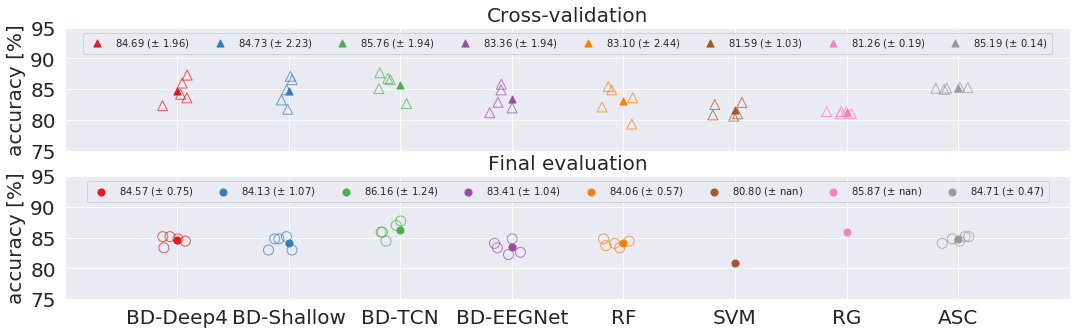

In [21]:
# nice seed to show all markers of individual runs and avoid overlapping
np.random.seed(13)
result_df = plot_result_overview(ylim=(75,95))